In [1]:
import numpy as np
import pandas as pd
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.feature_extraction.text import TfidfVectorizer
import string
import matplotlib.pyplot as plt

In [2]:
df_movie_details = pd.read_json('../data/IMDB_movie_details.json', lines = True)
df_reviews = pd.read_pickle('../data/cleaned_reviews.pkl.gz', compression = 'gzip')

In [3]:
#Tokenize
df_movie_details['tokenized_synopsis'] = list(map(word_tokenize, df_movie_details['plot_synopsis']))

In [4]:
# Remove stop words
stop_words_and_punctuations = set(stopwords.words('english') + list(string.punctuation))
df_movie_details['tokenized_synopsis'] = list(map(lambda x: [word.lower() for word in x if word.lower() not in stop_words_and_punctuations], df_movie_details['tokenized_synopsis']))

In [5]:
# Stemming
stemmer = PorterStemmer()
df_movie_details['tokenized_synopsis'] = list(map(lambda x: [stemmer.stem(word) for word in x], df_movie_details['tokenized_synopsis']))

In [6]:
df_movie_details['text_tokenized'] = list(map(lambda x: ' '.join(x), df_movie_details['tokenized_synopsis']))
df_movie_details = df_movie_details[df_movie_details['text_tokenized'] != '']
df_reviews = df_reviews[df_reviews['movie_id'].isin(df_movie_details['movie_id'])]
df_movie_details.to_pickle("../data/cleaned_synopsis.pkl.gz", compression = 'gzip')

In [3]:
df_movie_details = pd.read_pickle("../data/cleaned_synopsis.pkl.gz", compression = "gzip")

In [12]:
df_movie_details['text_tokenized'][0]

"jack ryan ford `` work vacat '' london famili retir cia professor us naval academi seen deliv lectur royal naval academi london.meanwhil ryan 's wife cathi daughter salli sightse near buckingham palac salli cathi come upon british royal guard salli tri get guard react improvis tap danc front 's impress guard train ignor distract n't react leave.a salli cathi walk away guard en rout rendezv ryan walk stolen cab sit three ulster liber armi terrorist kevin o'donnel driver well sean miller sean bean younger brother patrick three load bullet gun prepar carri schedul ambush lord william holm british secretari state northern ireland distant member british royal famili cousin queen mother finish load weapon anoth terrorist annett radio lord holm leav palac wife son.a lord holm 's car leav palac terrorist car fall line behind follow car head ambush point drive o'donnel miller brother ski masks.meanwhil ryan cross street meet wife daughter arriv time lord holm 's car pass area.suddenli anoth ca

In [4]:
df_reviews = df_reviews.drop(df_reviews[df_reviews.movie_id == "tt0104014"].index)
df_reviews = df_reviews.drop(df_reviews[df_reviews.movie_id == "tt0114142"].index)

In [78]:
movie_list = set(df_movie_details["movie_id"])
for movie_id in list(df_reviews["movie_id"].unique()):
    if movie_id not in movie_list:
        print(movie_id)

tt0104014
tt0114142


In [7]:
def fit_vectorizer(synopsis):
    vectorizer = TfidfVectorizer(stop_words='english')
    vectorizer.fit([synopsis])
    return vectorizer

# Apply the function to create a new column 'vectorizer'
df_movie_details['vectorizer'] = df_movie_details['text_tokenized'].apply(fit_vectorizer)

In [23]:
vectorizer = df_movie_details['vectorizer'][0]
print(vectorizer)
print([df_movie_details['text_tokenized'][0]])
vectorizer.transform([df_movie_details['text_tokenized'][0]])

TfidfVectorizer(stop_words='english')
["jack ryan ford `` work vacat '' london famili retir cia professor us naval academi seen deliv lectur royal naval academi london.meanwhil ryan 's wife cathi daughter salli sightse near buckingham palac salli cathi come upon british royal guard salli tri get guard react improvis tap danc front 's impress guard train ignor distract n't react leave.a salli cathi walk away guard en rout rendezv ryan walk stolen cab sit three ulster liber armi terrorist kevin o'donnel driver well sean miller sean bean younger brother patrick three load bullet gun prepar carri schedul ambush lord william holm british secretari state northern ireland distant member british royal famili cousin queen mother finish load weapon anoth terrorist annett radio lord holm leav palac wife son.a lord holm 's car leav palac terrorist car fall line behind follow car head ambush point drive o'donnel miller brother ski masks.meanwhil ryan cross street meet wife daughter arriv time lord 

<1x413 sparse matrix of type '<class 'numpy.float64'>'
	with 413 stored elements in Compressed Sparse Row format>

In [8]:
# Creating new dataframe for Similarity measure
similarity_data = {'movie_id' : [], 'review_label' : [], 'review_tokenized' : [], 'vectorizer' : [], 'synopsis_tokenized' : [], 'synopsis_tfidf' : [], 'review_tfidf' : [], 'similarity_score':[]}
for idx in df_reviews.index:
    review = df_reviews.loc[idx, :]
    movie_id = review['movie_id']
    review_tokenized = review['text_tokenized']
    synopsis_tokenized = df_movie_details.loc[df_movie_details['movie_id'] == movie_id]['text_tokenized'].tolist()[0] #get tokenized synopsis of reviewed movie
    vectorizer = df_movie_details.loc[df_movie_details['movie_id'] == movie_id]['vectorizer'].tolist()[0]
    synopsis_tfidf = vectorizer.transform([synopsis_tokenized])
    review_tfidf = vectorizer.transform([review_tokenized])
    similarity_score = cosine_similarity(synopsis_tfidf, review_tfidf)
    review_label = review['is_spoiler']

    similarity_data['movie_id'].append(movie_id)
    similarity_data['review_tokenized'].append(review_tokenized)
    similarity_data['synopsis_tokenized'].append(synopsis_tokenized)
    similarity_data["review_label"].append(review_label)
    similarity_data['vectorizer'].append(vectorizer)
    similarity_data['synopsis_tfidf'].append(synopsis_tfidf)
    similarity_data['review_tfidf'].append(review_tfidf)
    similarity_data['similarity_score'].append(similarity_score)

similarity_df = pd.DataFrame(similarity_data)

In [35]:
similarity_df['similarity_score'] = similarity_df['similarity_score'].apply(lambda x: x[0][0])

In [36]:
similarity_df

,movie_id,review_label,review_tokenized,vectorizer,synopsis_tokenized,synopsis_tfidf,review_tfidf,similarity_score
0,tt0111161,True,oscar year shawshank redempt written direct fr...,TfidfVectorizer(stop_words='english'),1947 andi dufresn tim robbin banker main convi...,"(0, 639)\t0.018816915354100735\n (0, 638)\t...","(0, 639)\t0.04708816093480111\n (0, 637)\t0...",0.473596
1,tt0111161,True,shawshank redempt without doubt one brilliant ...,TfidfVectorizer(stop_words='english'),1947 andi dufresn tim robbin banker main convi...,"(0, 639)\t0.018816915354100735\n (0, 638)\t...","(0, 637)\t0.11547005383792514\n (0, 621)\t0...",0.466064
2,tt0111161,True,believ film best stori ever told film 'm tell ...,TfidfVectorizer(stop_words='english'),1947 andi dufresn tim robbin banker main convi...,"(0, 639)\t0.018816915354100735\n (0, 638)\t...","(0, 631)\t0.09245003270420485\n (0, 621)\t0...",0.502751
3,tt0111161,True,ye spoiler film emot impact find hard write co...,TfidfVectorizer(stop_words='english'),1947 andi dufresn tim robbin banker main convi...,"(0, 639)\t0.018816915354100735\n (0, 638)\t...","(0, 634)\t0.07216878364870323\n (0, 631)\t0...",0.418941
4,tt0111161,True,heart extraordinari movi brilliant indel perfo...,TfidfVectorizer(stop_words='english'),1947 andi dufresn tim robbin banker main convi...,"(0, 639)\t0.018816915354100735\n (0, 638)\t...","(0, 637)\t0.13678822577626595\n (0, 630)\t0...",0.531946
...,...,...,...,...,...,...,...,...
538823,tt0139239,False,go wise fast pure entertain assembl except cas...,TfidfVectorizer(stop_words='english'),film told chronolog format stori told four dif...,"(0, 579)\t0.17919532172715857\n (0, 578)\t0...","(0, 573)\t0.35355339059327373\n (0, 533)\t0...",0.068229
538824,tt0139239,False,well shall say one´ fun rate three plotlin ori...,TfidfVectorizer(stop_words='english'),film told chronolog format stori told four dif...,"(0, 579)\t0.17919532172715857\n (0, 578)\t0...","(0, 578)\t0.6666666666666666\n (0, 558)\t0....",0.045948
538825,tt0139239,False,go best movi ever seen 've seen lot movi read ...,TfidfVectorizer(stop_words='english'),film told chronolog format stori told four dif...,"(0, 579)\t0.17919532172715857\n (0, 578)\t0...","(0, 576)\t0.1690308509457033\n (0, 563)\t0....",0.235326
538826,tt0139239,False,call 1999 teenag version pulp fiction whatev w...,TfidfVectorizer(stop_words='english'),film told chronolog format stori told four dif...,"(0, 579)\t0.17919532172715857\n (0, 578)\t0...","(0, 556)\t0.3779644730092272\n (0, 488)\t0....",0.041680


In [34]:
similarity_df.to_pickle("../data/similarity.pkl.gz", compression = "gzip")

In [8]:
similarity_df = pd.read_pickle("../data/similarity.pkl.gz", compression = "gzip")

In [12]:
tfidfvectorizer = TfidfVectorizer()
tfidfvectorizer.fit(similarity_df["review_tokenized"] + similarity_df["synopsis_tokenized"])

TfidfVectorizer()

In [31]:
similarity_df['synopsis_tfidf']

0           (0, 639)\t0.018816915354100735\n  (0, 638)\t...
1           (0, 639)\t0.018816915354100735\n  (0, 638)\t...
2           (0, 639)\t0.018816915354100735\n  (0, 638)\t...
3           (0, 639)\t0.018816915354100735\n  (0, 638)\t...
4           (0, 639)\t0.018816915354100735\n  (0, 638)\t...
                                ...                        
538823      (0, 579)\t0.17919532172715857\n  (0, 578)\t0...
538824      (0, 579)\t0.17919532172715857\n  (0, 578)\t0...
538825      (0, 579)\t0.17919532172715857\n  (0, 578)\t0...
538826      (0, 579)\t0.17919532172715857\n  (0, 578)\t0...
538827      (0, 579)\t0.17919532172715857\n  (0, 578)\t0...
Name: synopsis_tfidf, Length: 538828, dtype: object

In [14]:
synopsis_tfidf

<573906x519982 sparse matrix of type '<class 'numpy.float64'>'
	with 269581411 stored elements in Compressed Sparse Row format>

In [15]:
review_tfidf = tfidfvectorizer.transform(similarity_df["review_tokenized"])

In [16]:
review_tfidf

<573906x519982 sparse matrix of type '<class 'numpy.float64'>'
	with 62630753 stored elements in Compressed Sparse Row format>

In [21]:
for idx in similarity_df.index:
    similarity_df.loc[idx, 'similarity_score'] = cosine_similarity(review_tfidf[idx], synopsis_tfidf[idx]).tolist()[0]

In [35]:
similarity_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 573906 entries, 0 to 573905
Data columns (total 5 columns):
 #   Column              Non-Null Count   Dtype  
---  ------              --------------   -----  
 0   movie_id            573906 non-null  object 
 1   review_label        573906 non-null  bool   
 2   review_tokenized    573906 non-null  object 
 3   synopsis_tokenized  573906 non-null  object 
 4   similarity_score    573906 non-null  float64
dtypes: bool(1), float64(1), object(3)
memory usage: 18.1+ MB


In [37]:
spoiler = similarity_df.loc[similarity_df["review_label"] == True]
non_spoiler = similarity_df.loc[similarity_df["review_label"] == False].sample(n = spoiler["review_label"].count())
similarity_df_new = pd.concat([spoiler, non_spoiler])

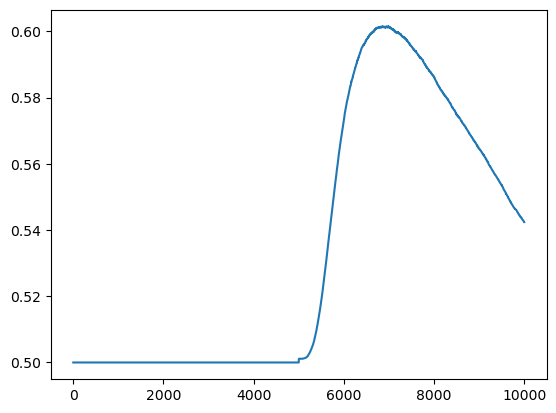

In [38]:
accuracy = []
max_acc = float('-inf')
for threshold in np.arange(-0.5, 0.5, 0.0001):
    pred = similarity_df_new["similarity_score"] > threshold
    acc = (pred == similarity_df_new["review_label"]).sum()/pred.count()
    accuracy.append(acc)
    max_acc = max(acc, max_acc)
plt.plot(accuracy)

In [39]:
max_acc

0.6014785932401177

In [44]:
similarity_df.groupby("review_label").count()

,movie_id,review_tokenized,synopsis_tokenized,similarity_score
review_label,,,,
False,422982,422982,422982,422982
True,150924,150924,150924,150924


In [ ]:
X_train, X_test, y_train, y_test = train_test_split(similarity_df_new['similarity_score'], similarity_df_new['is_spoiler'], test_size = 0.3, random_state = 23)

In [ ]:
logistic_model = LogisticRegression()
logistic_model.fit(X_train, y_train)

In [ ]:
logistic_model.score(X_test, y_test)

In [ ]:
print(confusion_matrix(y_test, logistic_model.predict(X_test)))

In [ ]:
ConfusionMatrixDisplay(confusion_matrix(y_test, logistic_model.predict(X_test))).plot()

In [ ]:
recall_score(y_test, logistic_model.predict(X_test))
print(classification_report(y_test, logistic_model.predict(X_test)))